*This notebook contains all the sample code and solutions to the exercises in chapter 2.*

The following cell is not shown either in the book. It creates the `images/end_to_end_project` folder (if it doesn't already exist), and it defines the `save_fig()` function which is used through this notebook to save the figures in high-res for the book.

In [1]:
# extra code – code to save the figures as high-res PNGs for the book

from pathlib import Path

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

## Download the Data

In [2]:
import pandas as pd
import tarfile
import urllib.request

params = {'csv_path': 'datasets/housing/housing.csv', 
          'folder_name': 'datasets', 
          'data_link': 'https://github.com/ageron/data/raw/main/housing.tgz', 
          'tarball_path': 'datasets/housing.tgz'}

# Function to automatically download data
def load_housing_data(csv_path, data_link, tarball_path, folder_name):
    tarball_path = Path(tarball_path)
    
    if not tarball_path.is_file(): 
        Path(folder_name).mkdir(parents=True, exist_ok=True) 
        url = data_link
        urllib.request.urlretrieve(url, tarball_path)
            
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path=folder_name)
    
    return pd.read_csv(Path(csv_path))

housing = load_housing_data(**params)

## Take a Quick Look at the Data Structure

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


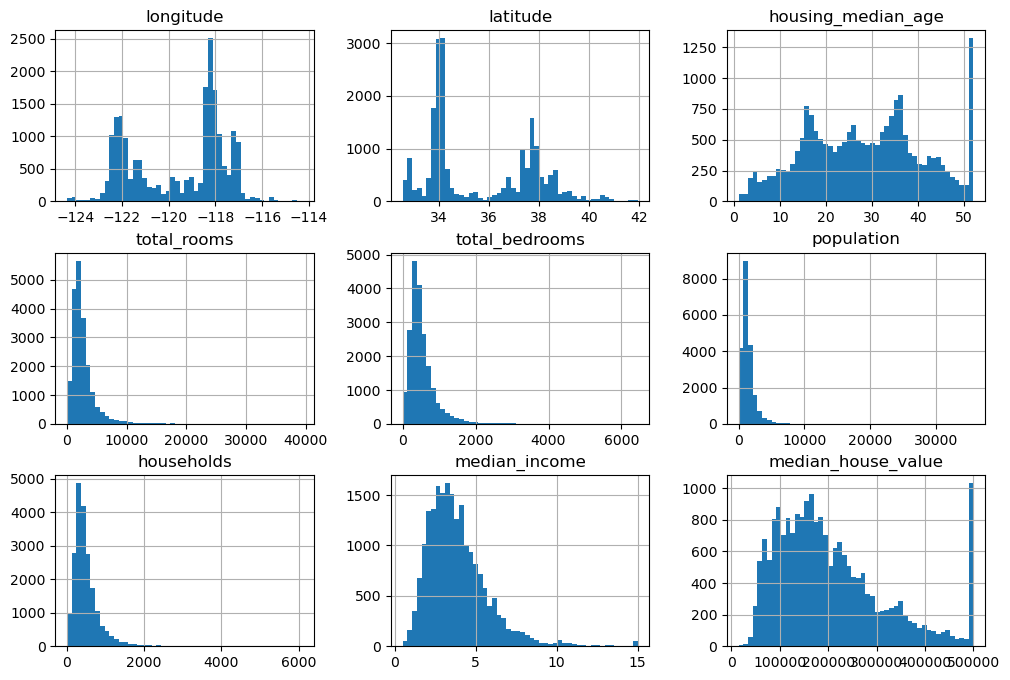

In [7]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12, 8))
plt.show()

# save_fig("attribute_histogram_plots")  # extra code

## Create a Test Set

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

test_set["total_bedrooms"].isnull().sum()

44

In [9]:
import numpy as np

# Create ordinal categorization labelled from 1 to 5
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

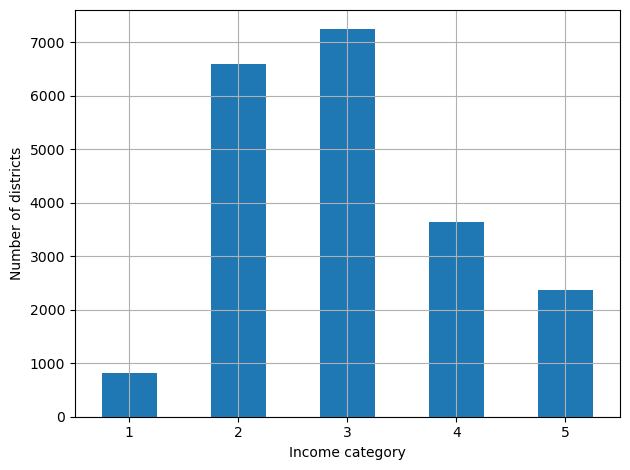

In [10]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")  # extra code
plt.show()

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [12]:
strat_train_set, strat_test_set = strat_splits[0]

It's much shorter to get a single stratified split:

In [13]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [14]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [15]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [16]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [17]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

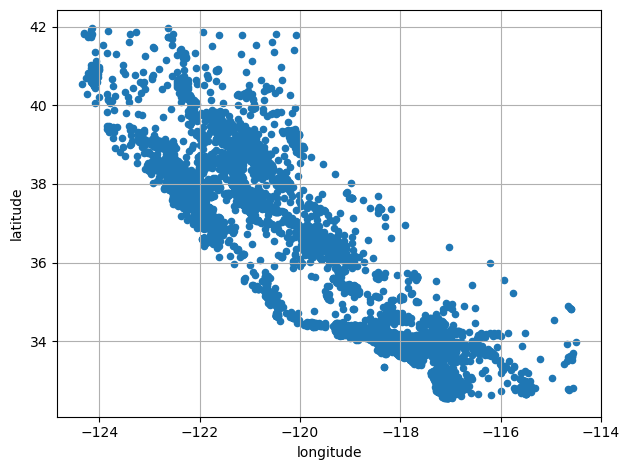

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")  # extra code
plt.show()

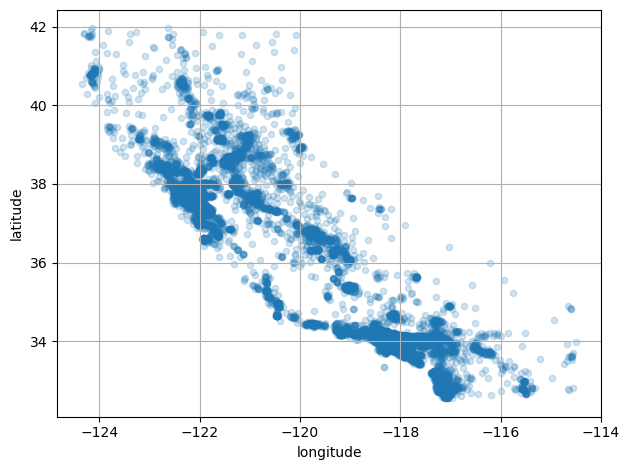

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")  # extra code
plt.show()

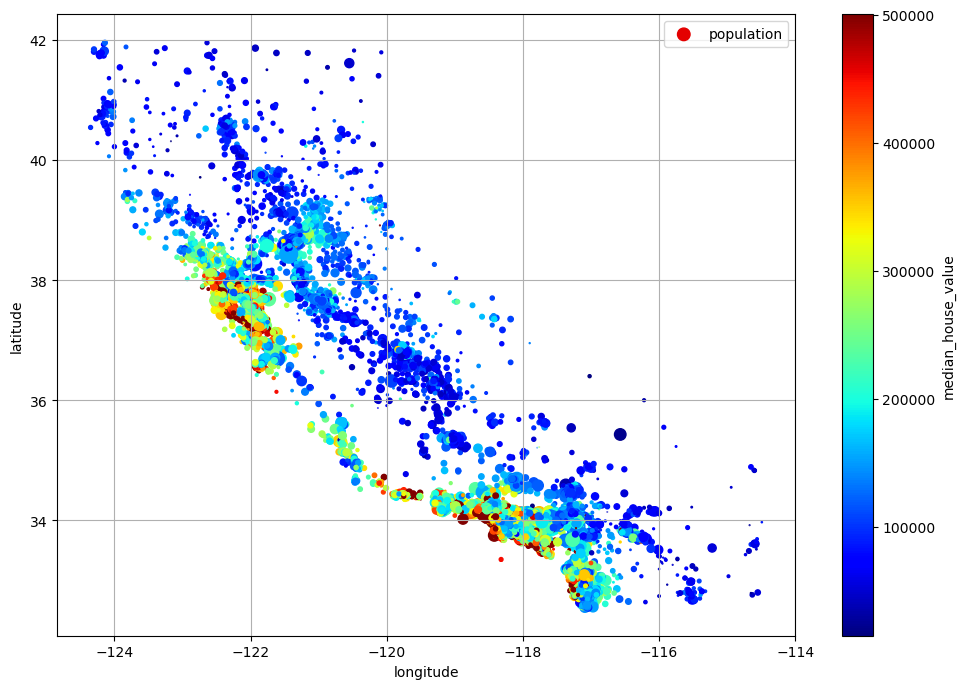

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
save_fig("housing_prices_scatterplot")  # extra code
plt.show()

The argument `sharex=False` fixes a display bug: without it, the x-axis values and label are not displayed (see: https://github.com/pandas-dev/pandas/issues/10611).

## Looking for Correlations

In [21]:
corr_matrix = housing.corr()

In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

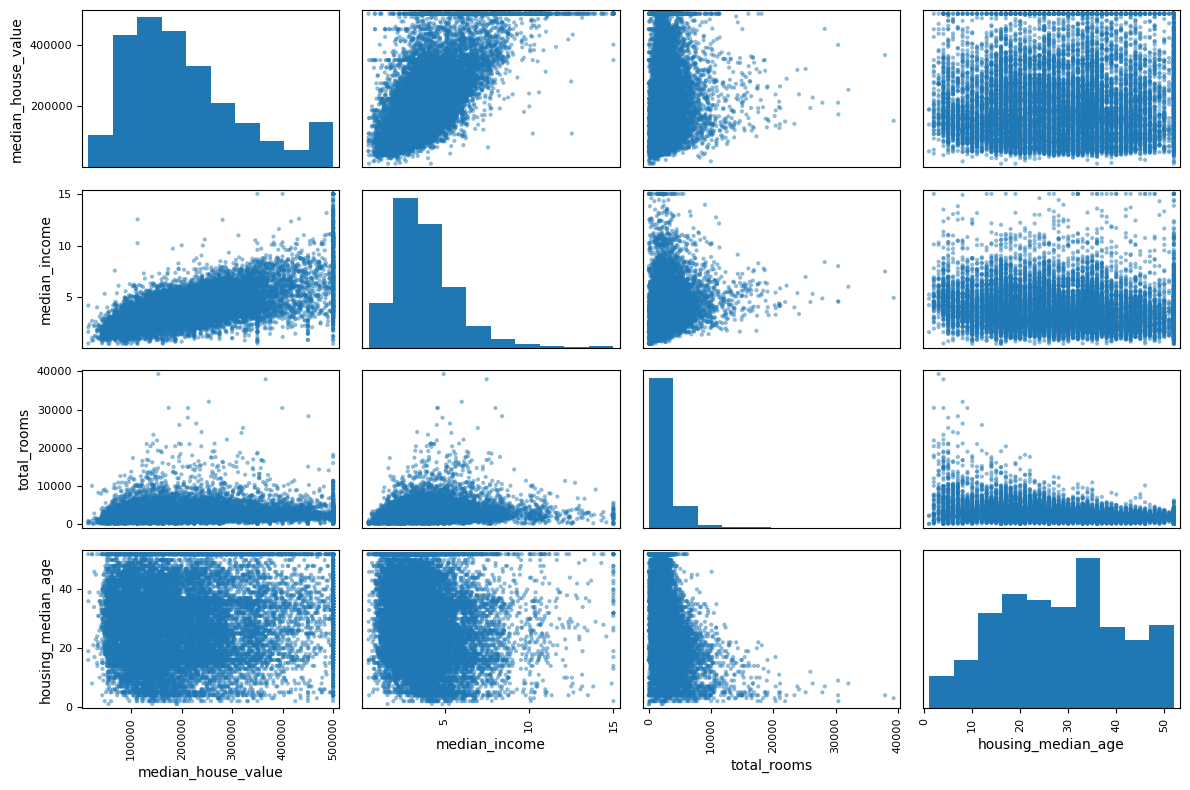

In [23]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

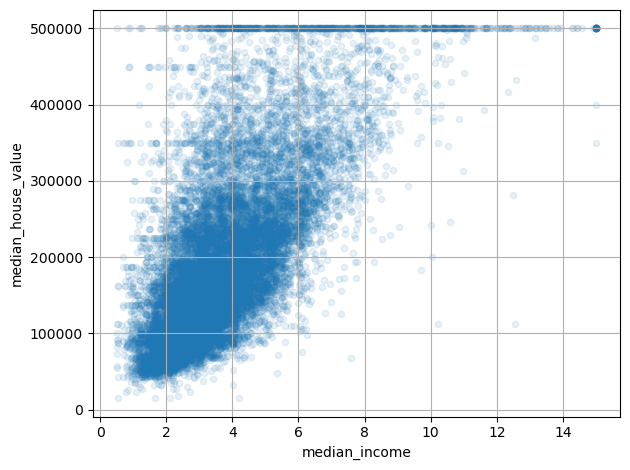

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")  # extra code
plt.show()

## Experimenting with Attribute Combinations

In [25]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [26]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [27]:
housing = strat_train_set.drop("median_house_value", axis=1)   # features
housing_labels = strat_train_set["median_house_value"].copy()  # target

## Data Cleaning

#### Useless

In the book 3 options are listed to handle the NaN values:

```python
housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

For each option, we'll create a copy of `housing` and work on that copy to avoid breaking `housing`. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [28]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [29]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [30]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [31]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


#### Real

In [32]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Separating out the numerical attributes to use the `"median"` strategy (as it cannot be calculated on text attributes like `ocean_proximity`):

In [33]:
housing_num = housing.select_dtypes(include=[np.number])
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


In [34]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [35]:
imputer.statistics_

# Double check results
# housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Transform the training set:

In [36]:
X = imputer.transform(housing_num)

In [37]:
pd.DataFrame(X)

# Optional
# imputer.feature_names_in_

,0,1,2,3,4,5,6,7
0,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
1,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
2,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
3,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
4,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
16507,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
16508,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
16509,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
16510,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


In [38]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [39]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [40]:
imputer.strategy

'median'

Now let's drop some outliers:

In [41]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [42]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

If you wanted to drop outliers, you would run the following code:

In [43]:
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [44]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [45]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# Output as sparse matrix
housing_cat_1hot

# Convert to array
# >>> housing_cat_1hot.toarray()

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [46]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Feature Scaling

In [48]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [49]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

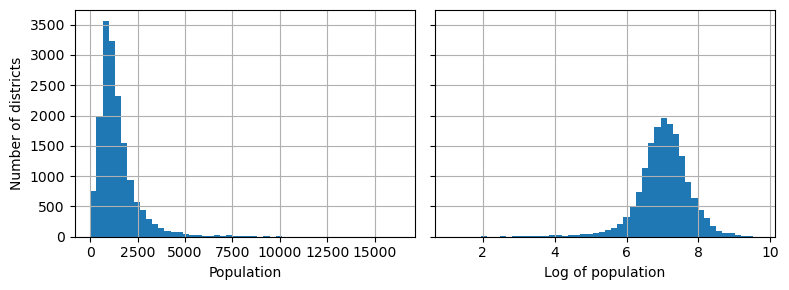

In [50]:
# extra code – this cell generates Figure 2–17
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)

# For labels
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

In [51]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [52]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame()) # Scaled targets

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [53]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [54]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers (shit i dont need)

To create simple transformers:

In [55]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [56]:
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


In [57]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [58]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [59]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [60]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [61]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [63]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [64]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [65]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

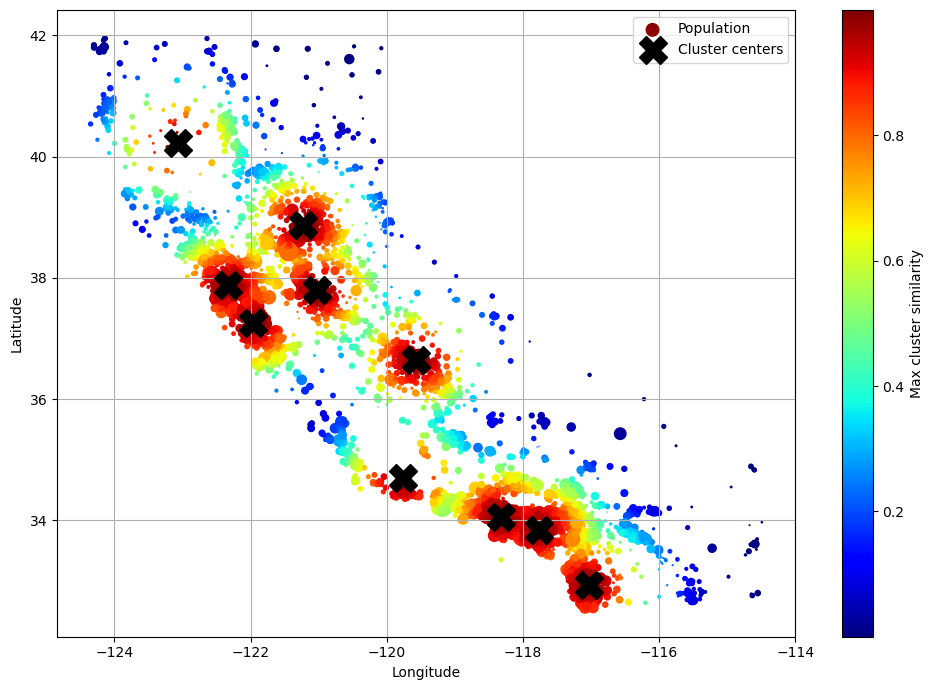

In [66]:
# extra code – this cell generates Figure 2–19

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

## Transformation Pipelines

Now let's build a pipeline to preprocess the numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

```Python 
# Alternative

from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
```

In [68]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [69]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [70]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

Monkey-patching SimpleImputer.get_feature_names_out()
Monkey-patching FunctionTransformer.get_feature_names_out()


In [71]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [72]:
df_housing_num_prepared.head(2)  # extra code

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


Sample codes

```Python 
num_pipeline.steps
num_pipeline[1]
num_pipeline[:-1]
num_pipeline.named_steps["impute"]
num_pipeline.set_params(simpleimputer__strategy="median")
```


In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


```Python
# Not the final code used

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]


preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

```

In [74]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [75]:
housing_prepared = preprocessing.fit_transform(housing)

In [76]:
# extra code – shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [77]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [78]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [79]:
housing_prepared

array([[ 1.84662439, -0.86602737, -0.33020372, ...,  1.        ,
         0.        ,  1.86111875],
       [-0.5081207 ,  0.0245495 , -0.25361631, ...,  0.        ,
         0.        ,  0.90762971],
       [-0.20215476, -0.04119332, -0.05104091, ...,  0.        ,
         0.        ,  0.35142777],
       ...,
       [-0.24249175, -0.10998748,  0.15854151, ...,  0.        ,
         1.        , -1.23772062],
       [ 0.25977479, -0.36093745, -0.21033248, ...,  0.        ,
         0.        ,  0.66925745],
       [ 3.61270996, -1.32397227,  0.04958379, ...,  0.        ,
         1.        ,  1.22545939]])

In [80]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [81]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027CC9A9F460>)])),
                ('linearregression', LinearRegression())])

Let's try the full preprocessing pipeline on a few training instances:

In [82]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([243700., 372400., 128800.,  94400., 328300.])

Compare against the actual values:

In [84]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [85]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-46.8%, -23.0%, 26.6%, -1.8%, -9.3%


In [86]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

68687.89176590182

In [87]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027CC9A9F460>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [88]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

0.0

## Better Evaluation Using Cross-Validation

In [89]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [90]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [93]:
tree_rmses

array([66506.70121103, 67097.20497743, 66144.65155743, 65069.22056897,
       64727.51994473, 70094.77824639, 67685.73110573, 68411.33556978,
       69293.5932016 , 63649.53649274])

In [92]:
# extra code – computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

**Warning:** the following cell may take a few minutes to run:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(forest_rmses).describe()

Let's compare this RMSE measured using cross-validation (the "validation error") with the RMSE measured on the training set (the "training error"):

In [ ]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

The training error is much lower than the validation error, which usually means that the model has overfit the training set. Another possible explanation may be that there's a mismatch between the training data and the validation data, but it's not the case here, since both came from the same dataset that we shuffled and split in two parts.

# Fine-Tune Your Model

## Grid Search

**Warning:** the following cell may take a few minutes to run:

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

You can get the full list of hyperparameters available for tuning by looking at `full_pipeline.get_params().keys()`:

In [ ]:
# extra code – shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

## Randomized Search

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

Try 30 (`n_iter` × `cv`) random combinations of hyperparameters:

**Warning:** the following cell may take a few minutes to run:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

In [ ]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

**Bonus section: how to choose the sampling distribution for a hyperparameter**

* `scipy.stats.randint(a, b+1)`: for hyperparameters with _discrete_ values that range from a to b, and all values in that range seem equally likely.
* `scipy.stats.uniform(a, b)`: this is very similar, but for _continuous_ hyperparameters.
* `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
* `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value.
* `scipy.stats.reciprocal(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.


Here are plots of the probability mass functions (for discrete variables), and probability density functions (for continuous variables) for `randint()`, `uniform()`, `geom()` and `expon()`:

In [ ]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

Here are the PDF for `expon()` and `reciprocal()` (left column), as well as the PDF of log(X) (right column). The right column shows the distribution of hyperparameter _scales_. You can see that `expon()` favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But `reciprocal()` does not favor any scale, they are all equally likely:

In [ ]:
# extra code – shows the difference between expon and reciprocal

from scipy.stats import reciprocal

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
reciprocal_distrib = reciprocal(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_reciprocal_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, reciprocal_distrib,
                 label="scipy.reciprocal(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_reciprocal_distrib,
                 label="log(X) with X ~ reciprocal")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

## Analyze the Best Models and Their Errors

In [ ]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

## Evaluate Your System on the Test Set

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

We could compute the interval manually like this:

In [ ]:
# extra code – shows how to compute a confidence interval for the RMSE
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

Alternatively, we could use a z-score rather than a t-score. Since the test set is not too small, it won't make a big difference:

In [ ]:
# extra code – computes a confidence interval again using a z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

## Model persistence using joblib

Save the final model:

In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

Now you can deploy this model to production. For example, the following code could be a script that would run in production:

In [ ]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [ ]:
predictions

You could use pickle instead, but joblib is more efficient.

# Exercise solutions

## 1.

Exercise: _Try a Support Vector Machine regressor (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Note that SVMs don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now (see the SVM notebook if you're interested). How does the best `SVR` predictor perform?_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                               3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

The best model achieves the following score (evaluated using 3-fold cross validation):

In [ ]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

That's much worse than the `RandomForestRegressor` (but to be fair, we trained the model on much less data). Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Exercise: _Try replacing the `GridSearchCV` with a `RandomizedSearchCV`._

**Warning:** the following cell will take several minutes to run. You can specify `verbose=2` when creating the `RandomizedSearchCV` if you want to see the training details.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': reciprocal(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    }

rnd_search = RandomizedSearchCV(svr_pipeline,
                                param_distributions=param_distribs,
                                n_iter=50, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

The best model achieves the following score (evaluated using 3-fold cross validation):

In [ ]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

Now that's really much better, but still far from the `RandomForestRegressor`'s performance. Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Note that we used the `expon()` distribution for `gamma`, with a scale of 1, so `RandomSearch` mostly searched for values roughly of that scale: about 80% of the samples were between 0.1 and 2.3 (roughly 10% were smaller and 10% were larger):

In [ ]:
np.random.seed(42)

s = expon(scale=1).rvs(100_000)  # get 100,000 samples
((s > 0.105) & (s < 2.29)).sum() / 100_000

We used the `reciprocal()` distribution for `C`, meaning we did not have a clue what the optimal scale of `C` was before running the random search. It explored the range from 20 to 200 just as much as the range from 2,000 to 20,000 or from 20,000 to 200,000.

## 3.

Exercise: _Try adding a `SelectFromModel` transformer in the preparation pipeline to select only the most important attributes._

Let's create a new pipeline that runs the previously defined preparation pipeline, and adds a `SelectFromModel` transformer based on a `RandomForestRegressor` before the final regressor:

In [ ]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),  # min feature importance
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [ ]:
selector_rmses = -cross_val_score(selector_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(selector_rmses).describe()

Oh well, feature selection does not seem to help. But maybe that's just because the threshold we used was not optimal. Perhaps try tuning it using random search or grid search?

## 4.

Exercise: _Try creating a custom transformer that trains a k-Nearest Neighbors regressor (`sklearn.neighbors.KNeighborsRegressor`) in its `fit()` method, and outputs the model's predictions in its `transform()` method. Then add this feature to the preprocessing pipeline, using latitude and longitude as the inputs to this transformer. This will add a feature in the model that corresponds to the housing median price of the nearest districts._

Rather than restrict ourselves to k-Nearest Neighbors regressors, let's create a transformer that accepts any regressor. For this, we can extend the `MetaEstimatorMixin` and have a required `estimator` argument in the constructor. The `fit()` method must work on a clone of this estimator, and it must also save `feature_names_in_`. The `MetaEstimatorMixin` will ensure that `estimator` is listed as a required parameters, and it will update `get_params()` and `set_params()` to make the estimator's hyperparameters available for tuning. Lastly, we create a `get_feature_names_out()` method: the output column name is the ...

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, clone

class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X, y)
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_
        if hasattr(self.estimator, "feature_names_in_"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self  # always return self!
    
    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions

    def get_feature_names_out(self, names=None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, "n_outputs_", 1)
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace("_", "")
        return [f"{estimator_short_name}_prediction_{i}"
                for i in range(n_outputs)]

Let's ensure it complies to Scikit-Learn's API:

In [ ]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

Good! Now let's test it:

In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = housing[["latitude", "longitude"]]
knn_transformer.fit_transform(geo_features, housing_labels)

And what does its output feature name look like?

In [ ]:
knn_transformer.get_feature_names_out()

Okay, now let's include this transformer in our preprocessing pipeline:

In [ ]:
from sklearn.base import clone

transformers = [(name, clone(transformer), columns)
                for name, transformer, columns in preprocessing.transformers]
geo_index = [name for name, _, _ in transformers].index("geo")
transformers[geo_index] = ("geo", knn_transformer, ["latitude", "longitude"])

new_geo_preprocessing = ColumnTransformer(transformers)

In [ ]:
new_geo_pipeline = Pipeline([
    ('preprocessing', new_geo_preprocessing),
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [ ]:
new_pipe_rmses = -cross_val_score(new_geo_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(new_pipe_rmses).describe()

Yikes, that's terrible! Apparently the cluster similarity features were much better. But perhaps we should tune the `KNeighborsRegressor`'s hyperparameters? That's what the next exercise is about.

## 5.

Exercise: _Automatically explore some preparation options using `RandomSearchCV`._

In [ ]:
param_distribs = {
    "preprocessing__geo__estimator__n_neighbors": range(1, 30),
    "preprocessing__geo__estimator__weights": ["distance", "uniform"],
    "svr__C": reciprocal(20, 200_000),
    "svr__gamma": expon(scale=1.0),
}

new_geo_rnd_search = RandomizedSearchCV(new_geo_pipeline,
                                        param_distributions=param_distribs,
                                        n_iter=50,
                                        cv=3,
                                        scoring='neg_root_mean_squared_error',
                                        random_state=42)
new_geo_rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

In [ ]:
new_geo_rnd_search_rmse = -new_geo_rnd_search.best_score_
new_geo_rnd_search_rmse

Oh well... at least we tried! It looks like the cluster similarity features are definitely better than the KNN feature. But perhaps you could try having both? And maybe training on the full training set would help as well.

## 6.

Exercise: _Try to implement the `StandardScalerClone` class again from scratch, then add support for the `inverse_transform()` method: executing `scaler.inverse_transform(scaler.fit_transform(X))` should return an array very close to `X`. Then add support for feature names: set `feature_names_in_` in the `fit()` method if the input is a DataFrame. This attribute should be a NumPy array of column names. Lastly, implement the `get_feature_names_out()` method: it should have one optional `input_features=None` argument. If passed, the method should check that its length matches `n_features_in_`, and it should match `feature_names_in_` if it is defined, then `input_features` should be returned. If `input_features` is `None`, then the method should return `feature_names_in_` if it is defined or `np.array(["x0", "x1", ...])` with length `n_features_in_` otherwise._

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X_orig = X
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        if hasattr(X_orig, "columns"):
            self.feature_names_in_ = np.array(X_orig.columns, dtype=object)
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    
    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        X = X * self.scale_
        return X + self.mean_ if self.with_mean else X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return getattr(self, "feature_names_in_",
                           [f"x{i}" for i in range(self.n_features_in_)])
        else:
            if len(input_features) != self.n_features_in_:
                raise ValueError("Invalid number of features")
            if hasattr(self, "feature_names_in_") and not np.all(
                self.feature_names_in_ == input_features
            ):
                raise ValueError("input_features ≠ feature_names_in_")
            return input_features

Let's test our custom transformer:

In [ ]:
from sklearn.utils.estimator_checks import check_estimator
 
check_estimator(StandardScalerClone())

No errors, that's a great start, we respect the Scikit-Learn API.

Now let's ensure the transformation works as expected:

In [ ]:
np.random.seed(42)
X = np.random.rand(1000, 3)

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, (X - X.mean(axis=0)) / X.std(axis=0))

How about setting `with_mean=False`?

In [ ]:
scaler = StandardScalerClone(with_mean=False)
X_scaled_uncentered = scaler.fit_transform(X)

assert np.allclose(X_scaled_uncentered, X / X.std(axis=0))

And does the inverse work?

In [ ]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))

assert np.allclose(X, X_back)

How about the feature names out?

In [ ]:
assert np.all(scaler.get_feature_names_out() == ["x0", "x1", "x2"])
assert np.all(scaler.get_feature_names_out(["a", "b", "c"]) == ["a", "b", "c"])

And if we fit a DataFrame, are the feature in and out ok?

In [ ]:
df = pd.DataFrame({"a": np.random.rand(100), "b": np.random.rand(100)})
scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ["a", "b"])
assert np.all(scaler.get_feature_names_out() == ["a", "b"])

All good! That's all for today! 😀

Congratulations! You already know quite a lot about Machine Learning. :)